# Labeling images using Amazon SageMaker Ground Truth

In this lab, you will learn how to create Amazon SageMaker Ground Truth job for labeling images. These labeled images will then be used as dataset for training a classification machine learning model in the following labs.

## Lab overview

##### Step 1. Upload the images to Amazon S3 bucket
##### Step 2. Create a labeling job in Amazon SageMaker Ground Truth
##### Step 3. Label images using the labeling tool of Amazon SageMaker Ground Truth
##### Step 4. Download the labeling result and process it for training

> When the notebook launchs for the first time, select **conda_mxnet_p36** for kernel.

## Step 0: Download bear images from Internet

Before you begin this lab, first let's download some bear and non-bear images from the Internet.

In [1]:
!pip install tqdm

In [2]:
!python download-images.py

saved an image as ./data/0005b6a438d43ecc.jpg
saved an image as ./data/000c897307728e2d.jpg
saved an image as ./data/004fb8e9af4341c3.jpg
saved an image as ./data/0061debb2a202214.jpg
saved an image as ./data/1f9a647ddb72a8c9.jpg
saved an image as ./data/155ea429631b28ac.jpg
saved an image as ./data/865a329e682983d8.jpg
saved an image as ./data/00574360e3de6cbb.jpg
saved an image as ./data/006a0958123deab1.jpg
saved an image as ./data/0089d4a84c4a3cd1.jpg
saved an image as ./data/008c2aaa599324b7.jpg


## Step 1: Upload the images to Amazon S3 Bucket

Replace the **S3_BUCKET** with your bucket name. We will use that S3 bucket to store images to be labelled and to store the labeling outputs. If the bucket does not exist, the below code will create one for you using the S3 bucket name you provide.

In [3]:
AWS_REGION = 'us-east-1'

# NOTE: S3 bucket name must begin with "deeplens-" for DeepLens deployment
S3_BUCKET = '<YOUR_BUCKET_NAME>' # must start with 'deeplens-'
S3_PREFIX = 'ground-truth-img-clf'
GT_JOB_NAME = 'deeplens-workshop'

Before we create the labeling job, it is always good to review the dataset. Here we randomly select 4 images and show them for your review.

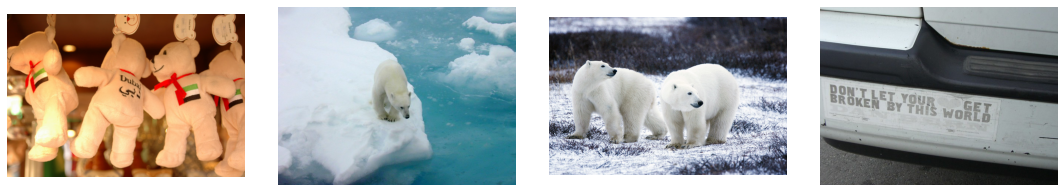

In [4]:
%matplotlib inline

import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_fnames = glob.glob('./data/*.jpg')

plt.figure(figsize=(15,10))

sample_images = random.sample(img_fnames, 4)

for i in range(len(sample_images)):
    img = mpimg.imread(sample_images[i])
    ax = plt.subplot(1, len(sample_images), i+1)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(img)

If you are okay with the images shown above, let's upload images to the S3 bucket so that Amazon SageMaker Ground Truth can use them for the labeling job we will soon create.

In [5]:
import boto3
from tqdm import tqdm
import sys
import time

s3 = boto3.resource('s3')

s3_bucket = s3.Bucket(S3_BUCKET)

if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
    print('Creating S3 bucket {}.'.format(S3_BUCKET))
    resp = s3.create_bucket(
        ACL='private',
        Bucket=S3_BUCKET
    )
    
print('>> Uploading images to be annotated to Amazon S3 bucket, {}\n'.format(S3_BUCKET))
time.sleep(1)
for img_fname in tqdm(img_fnames):#, file=sys.stdout):
    fname_only = img_fname.split('/')[-1]
    s3_key = '{}/images/{}'.format(S3_PREFIX, fname_only)
    s3_bucket.upload_file(img_fname, s3_key)

>> Uploading images to be annotated to Amazon S3 bucket, deeplens-fengmia



100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


## Step 2. Create a labeling job in Amazon SageMaker Ground Truth

Go to "Amazon SageMaker" web console, and select 'Ground Truth' > 'Labeling jobs' in the left menu.

### 1. Click on "Create labeling job"

![](./images/l400-lab1-1.png)

---
### 2. Fill in the job details

- **Job name**: labeling job name
- **Image dataset location**: Click on **Create manifest file** link

![](./images/l400-lab1-2.png)

---
### 3. Create **Manifest file**

- **Input dataset location**: s3://YOUR_S3_BUCKET_NAME/ground-truth-img-clf/images/
- **Data type**: Choose 'Images'
- Then, click on "Create" button

![](./images/l400-lab1-3.png)

* Click on "Use this manifest" button.

![](./images/l400-lab1-3-2.png)

Once you complete the above tasks, fill in  **Output dataset location** with the S3 location where you want to store the labeling result. 

Here let's use; __s3://YOUR_S3_BUCKET/ground-truth-img-clf/outputs__

![](./images/l400-lab1-3-3.png)

Next, we create an IAM Role which is used by Amazon SageMaker Ground Truth service by

- Choosing 'Create a new role',
- Selecting "Any S3 Bucket" in the pop-up window,
- and clicking on 'Create' button

Once the pop-up window disapears, select the newly created IAM Role from the list.

> **Note**: If you want to allow SageMaker Ground Truth to access a certain S3 bucket, put the desired bucket name in "Specific S3 buckets' rather than choosing "Any S3 Buckets"

![](./images/l400-lab1-3-4.png)
![](./images/l400-lab1-3-5.png)

---
### 4. Select a take type

In this lab, we build an image classification model. So, please select 'Image' for **Task category'** and 'Image classification' for **Task selection**.

![](./images/l400-lab1-4.png)

---
### 5. Select workers and configure tool

* **Worker types**: Select "Private" to use your own labeling workers
* **Team name**: Put the team name of your workers
* **Invite private annotators**: Put email addresses of labeling workers seperated by commas

After this step, you can add more workers via 'Private' > 'Workers' > 'Invite new workers' in **SageMaker > Ground Truth > Labelling workforces**


![](./images/l400-lab1-5-1.png)

In the 'Image classification labeling tool', fill out the description with the labeling guide, and add 3 labels under 'Select an option'. The three labels are "brown bear", "polar bear" and "no bear", one of which will be selected by workers for a given image.

Once all are filled, click on "Create" button at the bottom.

![](./images/l400-lab1-5-2.png)

## Step 3. Label images using the labeling tool of Amazon SageMaker Ground Truth


---
### 1. Check out the email sent to the worker email

Once the labeling job is created, workers will receive an email which includes log-in information(user name, temporal password) and URL of the labeling tool. Workers can start labeling using these information.

URL of the labeling tool can be also found in 'Private workforace summary' under 'Private' tab in **SageMaker > Ground Truth > Labelling workforce** menu.

![](./images/l400-lab1-6.png)

---
### 2. Annotate images using the labeling tool

When you login to the labeling tool using the provided URL, the jobs assigned to you will be listed. Select one in the list, and click on "Start working" button.

![](./images/l400-lab1-7.png)

An image is shown as below. Select one of "brown bear", "polar bear", and "no bear" based on the bear shown in the image. Then, click on "Submit" button at the bottom to move to the next image.

![](./images/l400-lab1-7-2.png)

## Step 4. Download the labeling result and process it for training

---
### 1. Check the labeling result

Go to **SageMaker > Ground Truth > Labelling jobs** to see the labeling job progress and the result.

![](./images/l400-lab1-8.png)

In the "Output dataset location", there are 3 folders; annotation-tool, annotations, and manifests.

**annotations** folder has all the labeling output done by workers, and **manifests** folder has the final output manifest files. The final manifest file, output.manifest, is in a folder, manifests/output

**manifests/outputs/output.manifest** has the label for each images in JSON format;

```json
{
    "source-ref": "s3://Your-S3-US-EAST1/ground-truth-img-clf/images/0005b6a438d43ecc.jpg",
    "bear-or-not-bear": 2,
    "bear-or-not-bear-metadata":{
        "confidence":0.71,
        "job-name":"labeling-job/bear-or-not-bear",
        "class-name":"no bear",
        "human-annotated":"yes",
        "creation-date":"2019-11-05T07:37:09.461538",
        "type":"groundtruth/image-classification"
    }
}
```

---
### 2. Use output.manifest to prepare dataset

Using the final manifest file, you prepare the dataset to the format which is required by your training script.


```
.
└── train
    ├── brown
    ├── no
    └── polar
```

In this workshop, we will provide fully annotated dataset with more images. So, you can move to the next lab now.